##### Gaussian Process for Western Wheat

In [3]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import scipy.stats as st
import seaborn as sns
import scipy
# RELOAD ipynb
import import_ipynb
import GP_util #load modules that you want reloaded
import importlib
importlib.reload(GP_util) # reload full module
from GP_util import unique, select, distancematrix,linear_pixel
#import methods from reloaded modules

importing Jupyter notebook from GP_util.ipynb
importing Jupyter notebook from GP_util.ipynb


In [4]:
#datapath = '/home/brian/WesternWheat/Data/Processed/stripped_mini_maxseason_labeled_df_23.csv'
#datapath = '/home/brian/WesternWheat/Data/Processed/stripped_max_labeled_df_23.csv'
datapath = '/home/brian/WesternWheat/Data/Processed/maxdf_23.csv'
df = pd.read_csv(datapath)

df = select(df,n=200)
df, df_unique, zero_farm_idx, N_farms = unique(df)

there are 197 unique farms in loaded df


In [9]:
###########################
# ==== distance matrix ====
########################### 

distance,Dmatsq = distancematrix(df, distance_calc=True, sparse=False, dlim=75)


In [131]:
#========= given etasq,rho =========

etas = np.array([1,.1,.3,.5,.7,1,.7,.5])
rhos = np.linspace(1e-3,5e-5,8)
trho = {} #empty trace dict to store traces in
# ==== Model I want to reparm =====
GP = {}
counter = 0
for i in range(rhos.size):
    if rhos.size != etas.size:
        raise ValueError('rhos and etas not the same size')
    counter +=1
    with pm.Model() as GP[str(counter)]:

        # ====== covariance matrix ========
        #etasq = pm.HalfCauchy('etasq', .7) # sets maximum covariance ij
        etasq = etas[i] # pm.Uniform('etasq', 0,1) 
        #rhosq = pm.HalfCauchy('rhosq', 1.5e-6) # determines rate of covariance decline between farms
        rhosq = rhos[i] # pm.Uniform('rhosq',lower=0,upper=1e-5)
        sigmay = 1e-2
        # will have very small posterior because distances are so large in Dmatsq
        Kij = etasq*(np.exp(-rhosq*Dmatsq)+np.diag([sigmay]*Num_farms))
        #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed

        # ========== gaussian process ===========
        w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
        a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained
        #a = np.zeros(Num_farms)
        # ========== Linear Model =============== 
        u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
        #============ Likelihood ==============
        sigma = pm.Uniform('sigma', 0,2)
        #sigma = .8
        y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

        trho["trace{}".format(counter)] = pm.sample(2000,tune=500,chains=2)
    #tt = pm.sample(1000,tune=500,chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:14<00:00, 347.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:29<00:00, 167.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:33<00:00, 148.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains:  51%|█████     | 2540/5000 [00:16<00:15, 156.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_dia

KeyboardInterrupt: 

In [12]:
with pm.Model() as GP_true:

    # ====== covariance matrix ========
    etasq = pm.Gamma('etasq', 3,6) # sets maximum covariance ij
    
    lsq = pm.Gamma('lsq', 2,.007) # determines rate of covariance decline between farms
    
    sigmay = 1e-2
    # will have very small posterior because distances are so large in Dmatsq
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*N_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed
 
    # ========== gaussian process ===========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    #sigma = .8
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace = pm.sample(1000,tune=500,chains=2)


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w, lsq, etasq]
Sampling 2 chains: 100%|██████████| 3000/3000 [08:09<00:00,  5.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


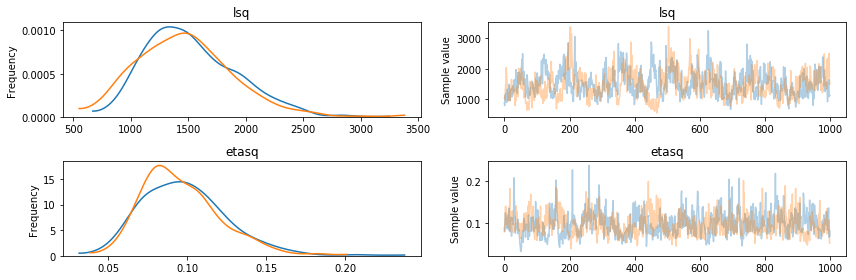

In [14]:
pm.traceplot(trace,varnames=['lsq','etasq']);

In [16]:
pm.summary(trace, varnames=['lsq','etasq','sigma','w'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lsq,1498.610595,410.581681,28.682106,788.648362,2322.355020,147.504424,1.003753
etasq,0.097114,0.026242,0.001421,0.051233,0.148339,236.578817,1.001387
sigma,0.890829,0.019076,0.000373,0.856108,0.932298,2766.712964,1.000011
w__0,0.262341,0.196711,0.003797,-0.123784,0.632976,2421.004442,1.000004
w__1,0.280338,0.219157,0.005781,-0.145317,0.704080,1290.636719,1.001458
w__2,0.242740,0.171097,0.003283,-0.089887,0.571935,2233.263032,1.000078
w__3,0.340990,0.170119,0.003796,0.030323,0.694459,2192.950457,1.000311
w__4,0.256625,0.133564,0.004358,0.005593,0.523356,935.161201,0.999672
w__5,0.475549,0.170533,0.004368,0.135862,0.802160,1597.093369,0.999651
w__6,0.276827,0.146461,0.004828,-0.005438,0.563301,1020.830332,1.000861


In [21]:
trace['step_size'].mean()

0.10720302057187095

In [43]:
rhos = np.array([8e-3,1e-4,9e-5,5e-5,1e-5,5e-6,1e-6,1e-7])
GP_e = {}
for i,r in enumerate(rhos):
    with pm.Model() as GP_e[str(i)]:

        # ====== covariance matrix ========
        #etasq = pm.HalfCauchy('etasq', .7) # sets maximum covariance ij
        etasq = .2
        #rhosq = pm.HalfCauchy('rhosq', 1.5e-6) # determines rate of covariance decline between farms
        rhosq = r 
        sigmay = 1e-2
        # will have very small posterior because distances are so large in Dmatsq
        Kij = etasq*(np.exp(-rhosq*Dmatsq)+np.diag([sigmay]*Num_farms))
        #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed

        # ========== gaussian process ===========
        w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
        a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained
        #a = np.zeros(Num_farms)
        # ========== Linear Model =============== 
        u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
        #============ Likelihood ==============
        sigma = pm.Uniform('sigma', 0,2)
        #sigma = .8
        y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

        GP_e['t{}'.format(i)] = pm.sample(2000,tune=500,chains=2)

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:40<00:00, 31.16draws/s]
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:05<00:00, 61.36draws/s] 
The number of effective samples is smaller than 25% for some parameters.


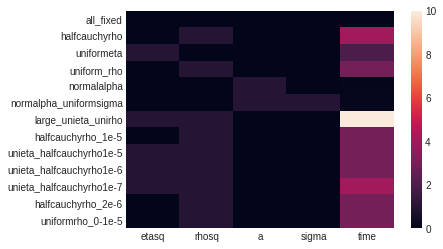

In [179]:
# 1 hr 45 min for 800 farms 3000 samples
# 1 hr 45 min for 800 farms 3000 samples but poor n_eff with uncentered, cauchy priors
computetime = {'all_fixed':[0,0,0,0,.05],'halfcauchyrho':[0,1,0,0,4],'uniformeta':[1,0,0,0,2],
               'uniform_rho':[0,1,0,0,3],'normalalpha':[0,0,1,0,.1],
               'normalpha_uniformsigma':[0,0,1,1,.15],'large_unieta_unirho':[1,1,0,0,10.],
              'halfcauchyrho_1e-5':[0,1,0,0,3.],'unieta_halfcauchyrho1e-5':[1,1,0,0,3],
              'unieta_halfcauchyrho1e-6':[1,1,0,0,3],'unieta_halfcauchyrho1e-7':[1,1,0,0,4],
              'halfcauchyrho_2e-6':[0,1,0,0,3.],'uniformrho_0-1e-5':[0,1,0,0,3.],
              'covsigma0.5' : [1,1,1,1,2]}
                    
                             
comptime = pd.DataFrame.from_dict(computetime, orient='index',
   columns=['etasq','rhosq','a','sigma','time'])

sns.heatmap(comptime);

In [207]:
X = df_unique.Latitude.values[:,None]
Xu = X[::]
# ===== reparam ====

with pm.Model() as GP_reparam:
    
    r""" 
    
    Trying to model two levels of a hierarchy, similar to a bayesian hierarchical model, 
    except, using a Gaussian Process to shrink the lower level estimates to the mean of the 
    higher level group. That way I do not have to define discrete groups that each farm belong to, 
    but can share information from farm to farm based on how close it is to other farms.
    This measure of similarity is given by the kernel function which defines a covariance matrix
    for the Gaussian Process. The trick is inserting my linear submodel.
    
    """
    
    # ======== prior intercept =============
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained unique to each farm
    b = pm.Normal('b', 0, .5, shape=Num_farms) # slope to be trained unique to each farm
    # ========== Linear Model =============== 
    u = a[zero_farm_idx]  + b[zero_farm_idx]*df.zprsum3 
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    y = pm.Normal('NDVI', mu=u, sd=sigma, observed=df.zNDVIsum3)
    

    # ========== gaussian process ===========
    #kernel hyperparameter lengthscale
    rho = pm.HalfCauchy('rho', .5)
    rho =.1
    #kernel
    cov = pm.gp.cov.ExpQuad(1,ls=rho)
    gp = pm.gp.MarginalSparse(cov_func=cov)
    # initialize 20 inducing points with K-means
    Xu = pm.gp.util.kmeans_inducing_points(20, X)
    sigma_gp = pm.Normal('sigma_gp',0,.5)
    # slope for the individual farms, need y to be output from y above
    w = gp.marginal_likelihood('w', X=X,Xu=Xu,y=b,noise=sigma_gp,is_observed=False)
    
 

    #trace = pm.sample(1000,tune=100,chains=1)
    #mp = pm.find_MAP()

In [78]:
compare_df = pm.compare({GP_e['0']:GP_e['t0'],GP_e['1']:GP_e['t1'],
            GP_e['2']:GP_e['t2'],GP_e['3']:GP_e['t3'],GP_e['4']:GP_e['t4'],
          GP_e['5']:GP_e['t5'],GP_e['6']:GP_e['t6'],GP_e['7']:GP_e['t7'],
                         GP_true:trace}) 

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-pack

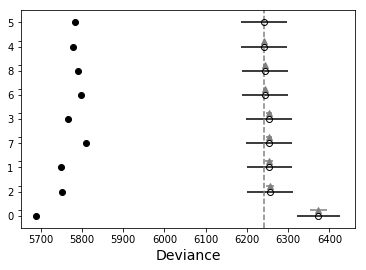

In [80]:
pm.compareplot(compare_df);

In [81]:
compare_df, compare_df.loc[]

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
5,6240.84,228.48,0,0,55.22,0,1
4,6241.31,231.3,0.47,0.4,55.23,2.5,1
8,6243.34,226.26,2.5,0,55.31,4.16,1
6,6244.19,223.39,3.35,0.4,55.23,5.03,1
3,6253.46,243.72,12.63,0,55.35,7.09,1
7,6253.47,221.19,12.64,0,55.21,8.28,1
1,6254.37,252.86,13.54,0.2,55.37,9.57,1
2,6255.77,252.24,14.93,0,55.44,9.24,1
0,6373.4,342.51,132.56,0,52.48,20.58,1


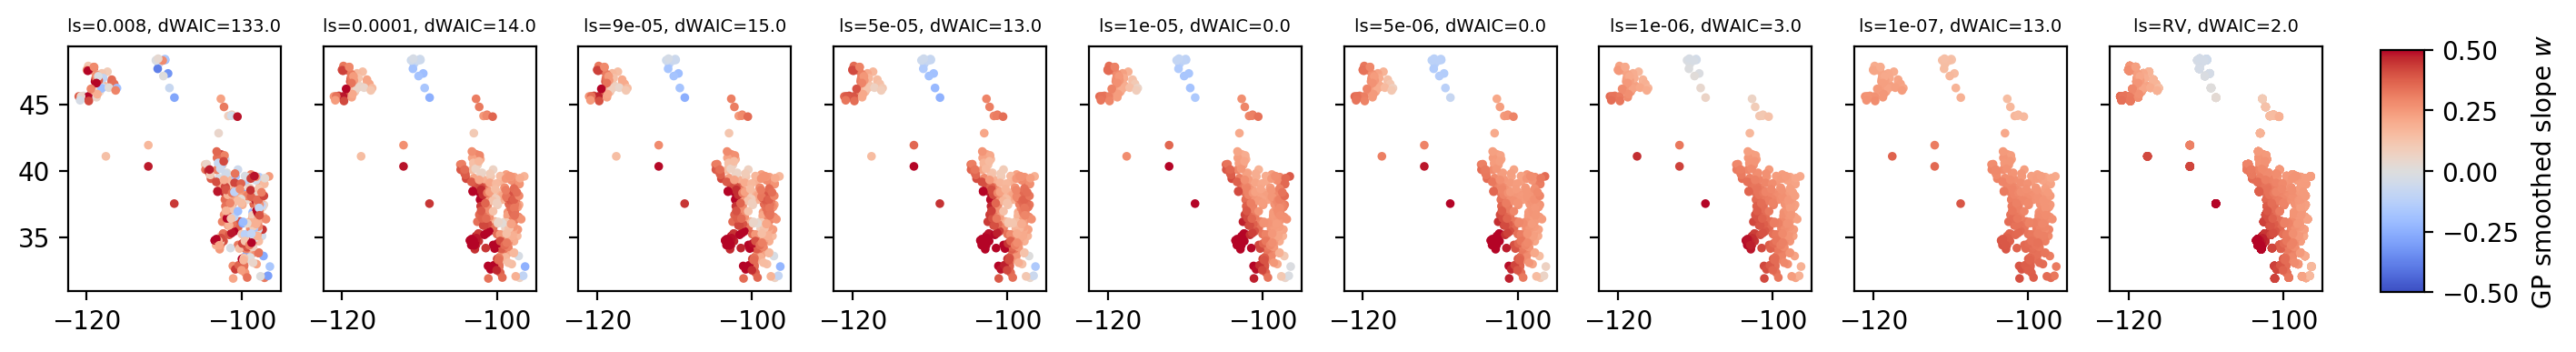

In [90]:
v=.5
fig, ax = plt.subplots(1,rhos.size+1,sharey=True,sharex=True,figsize=(rhos.size*2,rhos.size/4.5),dpi=200)

for i, r in enumerate(rhos):

    ax[i].set_title('ls={}, dWAIC={}'.format(round(r,7),round(compare_df.loc[i].dWAIC)),fontsize=7)
    im = ax[i].scatter(df_unique.Longitude,df_unique.Latitude,c=GP_e['t{}'.format(i)]['w'].mean(axis=0),
        cmap='coolwarm',vmax=v,vmin=-v,s=6)
    
    ax[8].set_title('ls=RV, dWAIC={}'.format(round(compare_df.loc[8].dWAIC)),fontsize=7)
    ax[8].scatter(df_unique.Longitude,df_unique.Latitude,c=trace['w'].mean(axis=0),
        cmap='coolwarm',vmax=v,vmin=-v,s=6)

cax = plt.axes([.92, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label='GP smoothed slope $w$');
plt.savefig('24_rho_SA_RVoneby9.png');

KeyError: 'trace1'

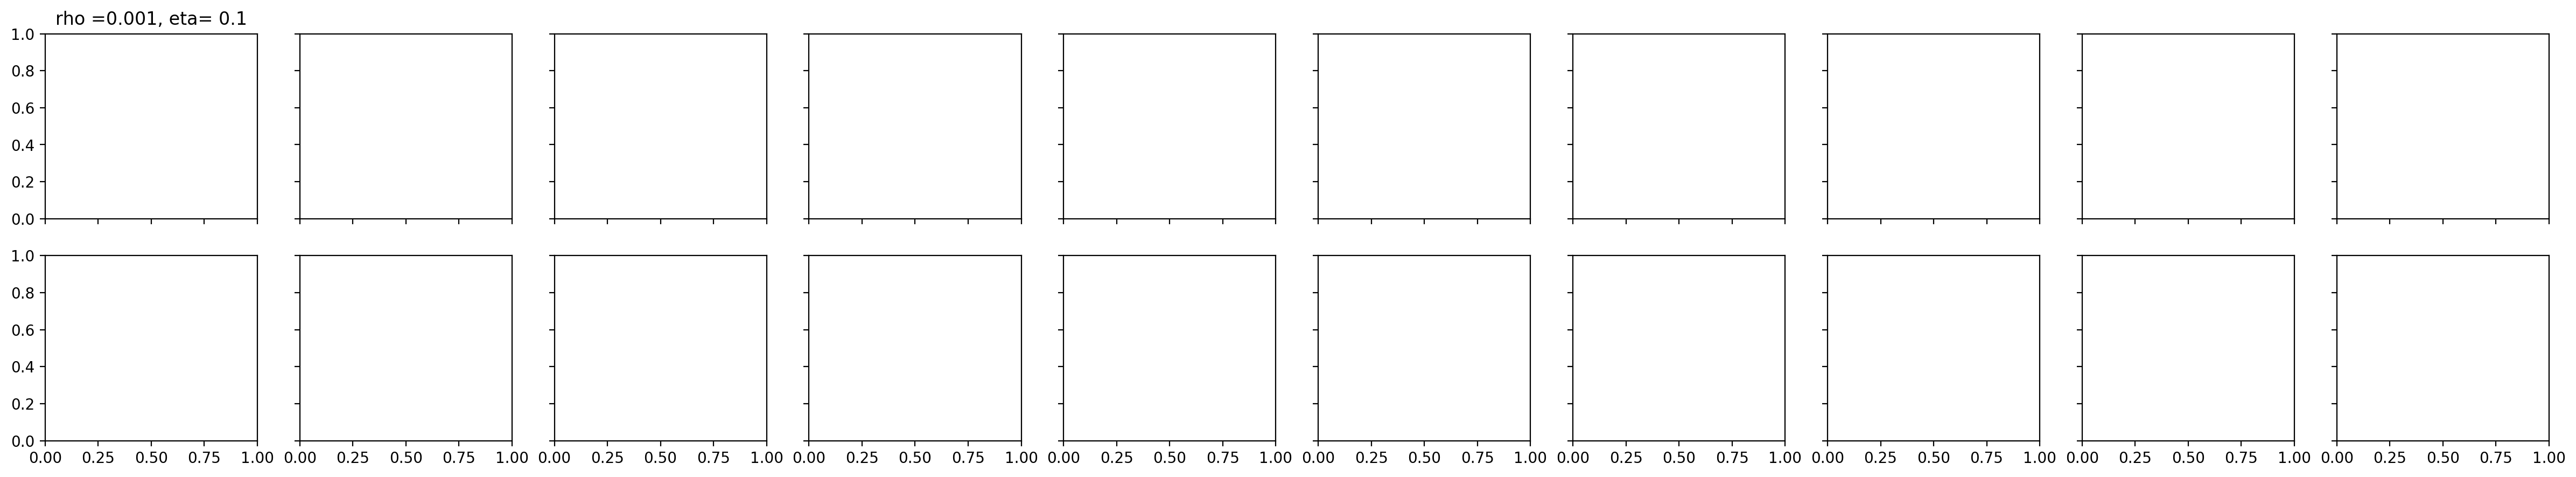

In [109]:
etas = np.array([.1,1])
rhos = np.linspace(1e-3,1e-5,10)
v=.5
fig, ax = plt.subplots(2,10,sharey=True,sharex=True,figsize=(30,5),dpi=200)

c = 0
for i, r in enumerate(rhos):
    for j,e in enumerate(etas):
        ax[j,i].set_title('rho ={}, eta= {}'.format((round(r,6)),e))
        im = ax[j,i].scatter(df_unique.Longitude,df_unique.Latitude,c=GP_e['t{}'.format()]['w'].mean(axis=0),
            cmap='coolwarm',vmax=v,vmin=-v,s=6)
        c += 1

#ax[2,i+1].scatter(df_unique.Longitude,df_unique.Latitude,c=t_highrho['trace{}'.format(i+1)]['w'].mean(axis=0),
#            cmap='coolwarm',vmax=v,vmin=-v,s=6)
    
    
#plt.subplots_adjust(bottom=0.1, right=0.99, top=0.9)
#cax = plt.axes([1, 0.1, 0.015, 0.75]) #right,bottom,width,top 
cax = plt.axes([.92, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label='GP smoothed slope $w$');
#plt.savefig('rho_eta_SA_2by10.png');

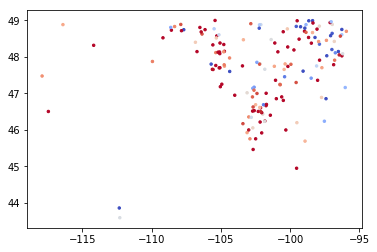

In [96]:
plt.scatter(df_unique.Longitude,df_unique.Latitude,c=df_unique.B_zprsum3,
            cmap='coolwarm',vmax=v,vmin=-v,s=6);

In [209]:
# add the GP conditional to the model, given the new X values
X_new = np.linspace(40,50,100)[:,None]#np.linspace(40,50,100)[:,None]
#with GP_reparam:
#    f_pred = gp.conditional("f_pred", X_new)
    
#with GP_reparam:
#    fs =  gp.conditional('fss', X_new)
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
#with GP_reparam:
#    pred_samples = pm.sample_posterior_predictive([trace], vars=[fs], samples=2000)

In [95]:
df_unique['B_zprsum3'] = 0
column_x='zprsum3'
for i,p in enumerate(df_unique.index):
    mu,C = linear_pixel(df, p, column_x=column_x,column_y='zNDVIsum3', c=None,cluster=False)
    df_unique.loc[(df_unique.index == p),'B_' + column_x] = mu[1]

{}

(60.0,
 Float64Index([   60.0,   317.0,   327.0,   396.0,   437.0,   445.0,   510.0,
                 524.0,   550.0,   570.0,
               ...
               49414.0, 49448.0, 49464.0, 49471.0, 49550.0, 49564.0, 49633.0,
               49737.0, 49855.0, 49885.0],
              dtype='float64', name='pixel', length=874))

## Pickling

In [107]:
import pickle

#df.to_pickle('maxdf_24_360p')
#df = pd.read_pickle(file_name)


In [108]:


with open('GP_e.p', 'wb') as fp:
    pickle.dump(GP_e, fp, protocol=pickle.HIGHEST_PROTOCOL)
    


NameError: name 'trace_n' is not defined